HPA_KF 737 回出現
HFA_KF 708 回出現
HPA_YS 725 回出現
HFA_YS 731 回出現


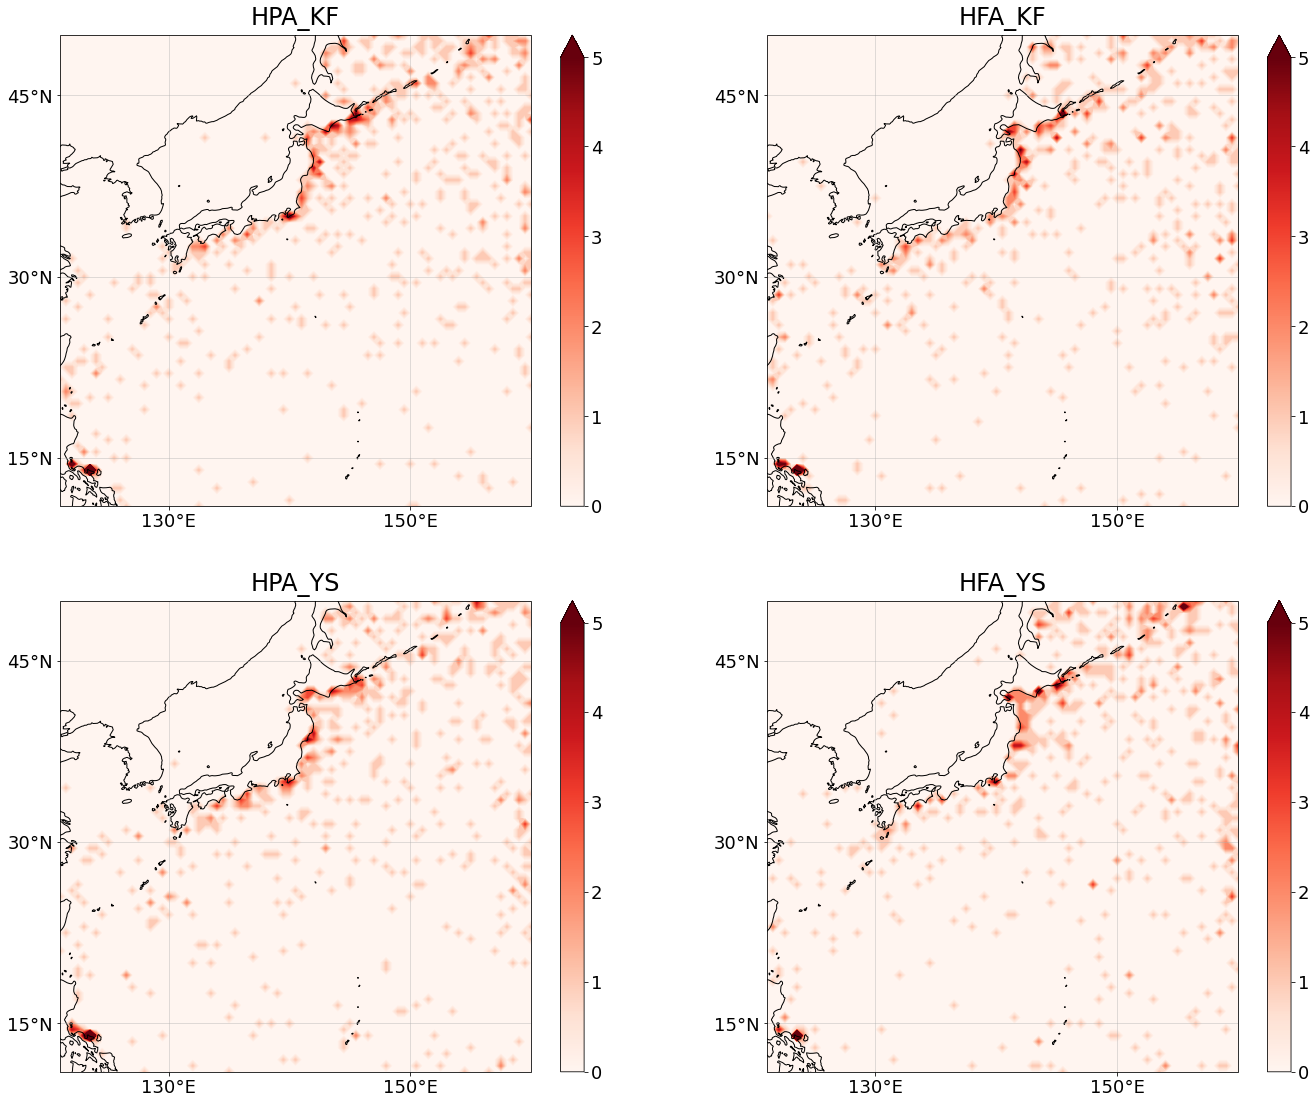

In [9]:
"""
イベントごとの空間最大値が起きた回数・場所をプロットする.
"""

from csv import reader
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as ticker

# 緯度経度の設定
with open('../lats.csv', 'r') as csv_file:
    csv_reader = reader(csv_file)
    lats = list(csv_reader)
with open('../lons.csv', 'r') as csv_file:
    csv_reader = reader(csv_file)
    lons = list(csv_reader)

for i in range(79):
    for j in range(79):
        lats[i][j] = float(lats[i][j])
        lons[i][j] = float(lons[i][j])

lat_s = lats[0][0]
lat_n = lats[0][-1]
lon_w = lons[0][0]
lon_e = lons[-1][0]

fig = plt.figure(figsize=(20, 16))
levels = np.arange(0, 5, 0.01)

MODEL = ['KF', 'YS']

for model_num in range(len(MODEL)):
    for num in range(2):
        model = MODEL[model_num]
        if num == 0:
            model = 'HPA_' + model
        else:
            model = 'HFA_' + model + '_c0'

        with open('../pot_csv/' + model + '_POT_DATA.csv', 'r') as csv_file:
            csv_reader = reader(csv_file)
            POT = list(csv_reader)
        with open('../pot_csv/' + model + '_POT_INDEX.csv', 'r') as csv_file:
            csv_reader = reader(csv_file)
            POT_INDEX = list(csv_reader)

        DATA = []  # [Hsのindex, Hs, 場所を表すindex]の配列
        for i in range(len(POT)):
            for j in range(len(POT[i])):
                DATA.append([int(POT_INDEX[i][j]), float(POT[i][j]), i])
        
        DATA.sort()

        last_index = 0
        max_val = 0
        POT = [[]]  # イベントごとのPOTを収納
        for data in DATA:
            if data[1] >= 24.170000305175783:
                continue
            if data[0] > last_index + 24 * 7:
                POT.append([data[0], data[1], data[2]])
                last_index = data[0]
                max_val = data[1]
            else:
                if data[1] > max_val:
                    POT[-1] = [data[0], data[1], data[2]]
                    last_index = data[0]
                    max_val = data[1]
        x = []
        y = []
        z = []
        for data in POT:
            x.append(data[0])
            y.append(data[1])
            z.append(data[2])

        cnt = np.zeros((79, 79))  # 台風発生頻度の空間分布
        for val in z:
            cnt[val // 79][val % 79] = cnt[val // 79][val % 79] + 1

        print(model[:6], len(x), '回出現')
        # 描画
        ax = fig.add_subplot(2, 2, 2 * model_num + num + 1, projection=ccrs.PlateCarree())
        a = plt.contourf(lons, lats, cnt, levels=levels, transform=ccrs.PlateCarree(), cmap='Reds', extend='max')
        c_bar = plt.colorbar(a, ticks=[0, 1, 2, 3, 4, 5])
        c_bar.ax.tick_params(labelsize=18)
        c_bar.ax.yaxis.set_minor_locator(ticker.NullLocator())
        ax.set_xticks([130,150], crs=ccrs.PlateCarree()) # gridを引く経度を指定 360にすると0Wが出ない
        ax.set_yticks([15, 30, 45], crs=ccrs.PlateCarree()) # gridを引く緯度を指定
        lon_formatter = LongitudeFormatter(zero_direction_label=True) # 経度
        lat_formatter = LatitudeFormatter() # 緯度。formatを指定することも可能
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.axes.tick_params(labelsize=18)
        ax.grid()
        ax.coastlines()
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.5) # 経度線・緯度線ラベルを無効
        gl.xlocator = ticker.FixedLocator([130, 150]) # 経度線
        gl.ylocator = ticker.FixedLocator([15, 30, 45]) # 緯度線
        ax.set_title(model[:6], fontsize=24, pad=10)

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)
plt.savefig("../img/frequency_of_tc.png")
plt.show()